## Loading the python packages

In [1]:
# Load packages

import numpy as np
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier

# Libraries for Deep Learning Models
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

# ✅ Use SciKeras instead of deprecated Keras wrappers
from scikeras.wrappers import KerasClassifier

## Loading the Dataset

In [2]:
# loading dataset
dataset = pd.read_csv('data.csv')

In [3]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Exploring the Dataset

In [4]:
# shape
dataset.shape

(475151, 13)

In [5]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Unnamed: 0,timestamp,Asset_ID,Asset_Name,Weight,Count,Open,High,Low,Close,Volume,VWAP,Target
475146,11388955,1633564500,6,NaN,NaN,282.0,3584.25,3584.57,3581.75,3583.68,72.2475,8360.880000,-0.000337
475147,11388956,1633564560,6,NaN,NaN,298.0,3583.68,3585.34,3583.68,3585.34,119.6195,8364.133333,-0.000101
475148,11388957,1633564620,6,NaN,NaN,652.0,3585.01,3588.70,3579.52,3580.06,532.7315,8361.573333,-0.000103
475149,11388958,1633564680,6,NaN,NaN,418.0,3580.07,3581.49,3576.79,3577.26,217.0207,8350.700000,-0.000007
475150,11388959,1633564740,6,NaN,NaN,686.0,3577.25,3577.63,3573.88,3574.89,290.6959,8343.140000,0.003081


In [6]:
# describe data
dataset.describe()

,Unnamed: 0,timestamp,Asset_ID,Asset_Name,Weight,Count,Open,High,Low,Close,Volume,VWAP,Target
count,4.751510e+05,4.751510e+05,475151.0,0.0,0.0,475151.000000,475151.000000,475151.000000,475151.000000,475151.000000,475151.000000,475151.000000,475151.000000
mean,1.927068e+07,1.623715e+09,6.0,NaN,NaN,1809.085501,2631.619927,2635.174219,2628.100504,2631.624981,1354.663745,3694.349218,0.000009
std,4.795869e+06,8.230443e+06,0.0,NaN,NaN,1987.296771,978.675154,978.882191,978.458916,978.675132,2006.650723,2903.753425,0.002730
min,9.172800e+06,1.609459e+09,6.0,NaN,NaN,1.000000,716.180192,718.730000,700.000000,716.170000,0.610079,716.405499,-0.049498
25%,1.924840e+07,1.616587e+09,6.0,NaN,NaN,765.000000,1829.493571,1832.000000,1827.110000,1829.500714,363.466156,1829.508105,-0.001231
50%,2.091137e+07,1.623714e+09,6.0,NaN,NaN,1226.000000,2442.037143,2446.300000,2437.625596,2442.122857,755.939424,2442.160164,-0.000043
75%,2.257424e+07,1.630842e+09,6.0,NaN,NaN,2083.000000,3377.180401,3381.855000,3372.015000,3377.240000,1546.813978,3561.182837,0.001162
max,2.423658e+07,1.637970e+09,6.0,NaN,NaN,66253.000000,4865.220000,4868.000000,4861.380000,4865.220000,84569.795205,11346.890000,0.066248


## Preparing the Dataset


### Cleaning the Data

In [7]:
# Checking if there are any null values
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [8]:
dataset=dataset.drop(columns=['Asset_Name','Weight'])

In [9]:
dataset.tail()

,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
475146,11388955,1633564500,6,282.0,3584.25,3584.57,3581.75,3583.68,72.2475,8360.880000,-0.000337
475147,11388956,1633564560,6,298.0,3583.68,3585.34,3583.68,3585.34,119.6195,8364.133333,-0.000101
475148,11388957,1633564620,6,652.0,3585.01,3588.70,3579.52,3580.06,532.7315,8361.573333,-0.000103
475149,11388958,1633564680,6,418.0,3580.07,3581.49,3576.79,3577.26,217.0207,8350.700000,-0.000007
475150,11388959,1633564740,6,686.0,3577.25,3577.63,3573.88,3574.89,290.6959,8343.140000,0.003081


In [10]:
print(dataset.columns)

Index(['Unnamed: 0', 'timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume',
       'VWAP', 'Target'],
      dtype='object')


### Preparing the Data for Classification

We attach a label to each movement:

*   1 if the signal is that short term price will go up as compared to the long term.
*   0 if the signal is that short term price will go down as compared to the long term.

In [11]:
# Create short simple moving average over a short 10-day-window
dataset['short_mvg'] = dataset['Close'].rolling(window=10, min_periods=1).mean()

# Create long simple moving average over a long 60-day-window
dataset['long_mvg'] = dataset['Close'].rolling(window=60, min_periods=1).mean()

# Create the signals
dataset['signal'] = np.where(dataset['short_mvg'] > dataset['long_mvg'], 1.0, 0.0)


In [12]:
dataset.tail(5)

,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,short_mvg,long_mvg,signal
475146,11388955,1633564500,6,282.0,3584.25,3584.57,3581.75,3583.68,72.2475,8360.880000,-0.000337,3583.231,3590.516833,0.0
475147,11388956,1633564560,6,298.0,3583.68,3585.34,3583.68,3585.34,119.6195,8364.133333,-0.000101,3583.466,3590.475000,0.0
475148,11388957,1633564620,6,652.0,3585.01,3588.70,3579.52,3580.06,532.7315,8361.573333,-0.000103,3583.271,3590.312833,0.0
475149,11388958,1633564680,6,418.0,3580.07,3581.49,3576.79,3577.26,217.0207,8350.700000,-0.000007,3583.083,3590.124500,0.0
475150,11388959,1633564740,6,686.0,3577.25,3577.63,3573.88,3574.89,290.6959,8343.140000,0.003081,3582.088,3589.895833,0.0


### Feature Extraction

We start by the constructing of the dataset that contains the predictors which will be used to make the predictions, and the output variable too.

The current Data of the Ethereum consists of open, high, low, close and volume. by using this data we can calculate the following technical indicators:



*   $Moving Average$ : A moving average provides an indication of the trend of the price movement by cut down the amount of noise on a price chart.
*   $Stochastic Oscillator %K and %D$ : A stochastic oscillator is a momentum
indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
*   $Relative Strength Index(RSI)$ :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
*   $Rate Of Change(ROC)$: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
*   $Momentum (MOM)$ : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.


In [13]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(Close, Low, High, n):
 STOK = ((Close - Low.rolling(n).min()) / (High.rolling(n).max() - Low.rolling(n).min())) * 100
 return STOK

def STOD(Close, Low, High, n):
 STOK = ((Close - Low.rolling(n).min()) / (High.rolling(n).max() - Low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [14]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

In [15]:
dataset.tail()

,Unnamed: 0,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
475146,11388955,1633564500,6,282.0,3584.25,3584.57,3581.75,3583.68,72.2475,8360.880000,...,50.465781,66.959385,45.958202,25.395504,24.535110,58.550819,58.215810,3583.231,3590.126667,3580.70865
475147,11388956,1633564560,6,298.0,3583.68,3585.34,3583.68,3585.34,119.6195,8364.133333,...,50.616184,87.387387,65.740617,32.306411,28.712184,61.241692,59.842222,3583.466,3590.087000,3580.69395
475148,11388957,1633564620,6,652.0,3585.01,3588.70,3579.52,3580.06,532.7315,8361.573333,...,50.129611,22.302158,58.882977,10.324729,22.675548,52.682769,57.491760,3583.271,3589.842000,3580.68020
475149,11388958,1633564680,6,418.0,3580.07,3581.49,3576.79,3577.26,217.0207,8350.700000,...,49.874085,3.946264,37.878603,1.894397,14.841846,48.143946,54.022802,3583.083,3589.287000,3580.67355
475150,11388959,1633564740,6,686.0,3577.25,3577.63,3573.88,3574.89,290.6959,8343.140000,...,49.658756,6.815115,11.021179,3.643579,5.287568,44.302156,48.376290,3582.088,3588.606333,3580.66940


In [16]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open','short_mvg','long_mvg'], axis=1)

In [17]:
dataset = dataset.dropna(axis=0)

In [18]:
dataset.tail()

,Unnamed: 0,timestamp,Asset_ID,Count,Close,Volume,VWAP,Target,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
475146,11388955,1633564500,6,282.0,3583.68,72.2475,8360.880000,-0.000337,0.0,3584.597988,...,50.465781,66.959385,45.958202,25.395504,24.535110,58.550819,58.215810,3583.231,3590.126667,3580.70865
475147,11388956,1633564560,6,298.0,3585.34,119.6195,8364.133333,-0.000101,0.0,3584.732900,...,50.616184,87.387387,65.740617,32.306411,28.712184,61.241692,59.842222,3583.466,3590.087000,3580.69395
475148,11388957,1633564620,6,652.0,3580.06,532.7315,8361.573333,-0.000103,0.0,3583.883281,...,50.129611,22.302158,58.882977,10.324729,22.675548,52.682769,57.491760,3583.271,3589.842000,3580.68020
475149,11388958,1633564680,6,418.0,3577.26,217.0207,8350.700000,-0.000007,0.0,3582.679048,...,49.874085,3.946264,37.878603,1.894397,14.841846,48.143946,54.022802,3583.083,3589.287000,3580.67355
475150,11388959,1633564740,6,686.0,3574.89,290.6959,8343.140000,0.003081,0.0,3581.262858,...,49.658756,6.815115,11.021179,3.643579,5.287568,44.302156,48.376290,3582.088,3588.606333,3580.66940


### Data Visualization

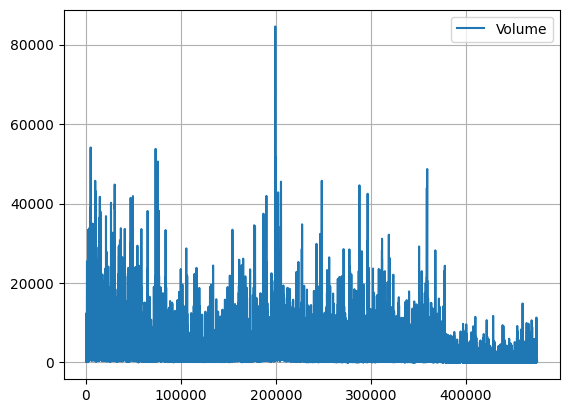

In [19]:
dataset[['Volume']].plot(grid=True)
plt.show()

#### Histograms

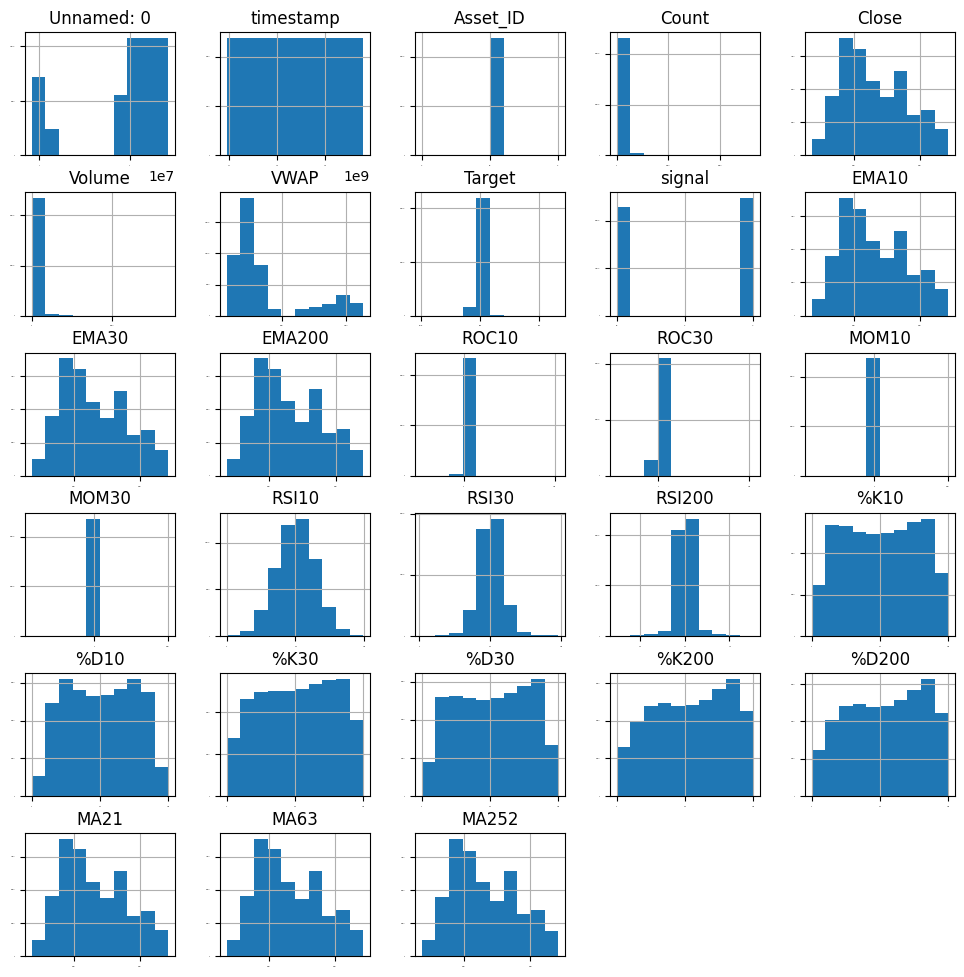

In [20]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

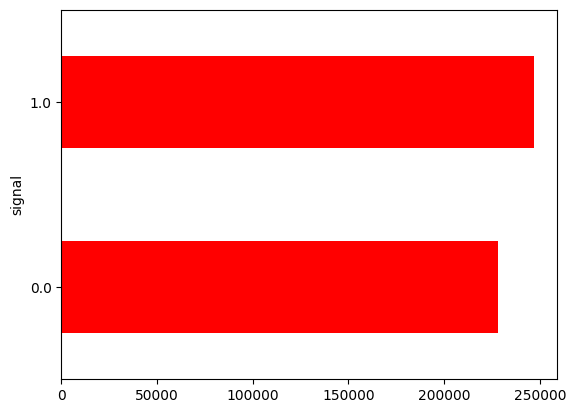

In [21]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

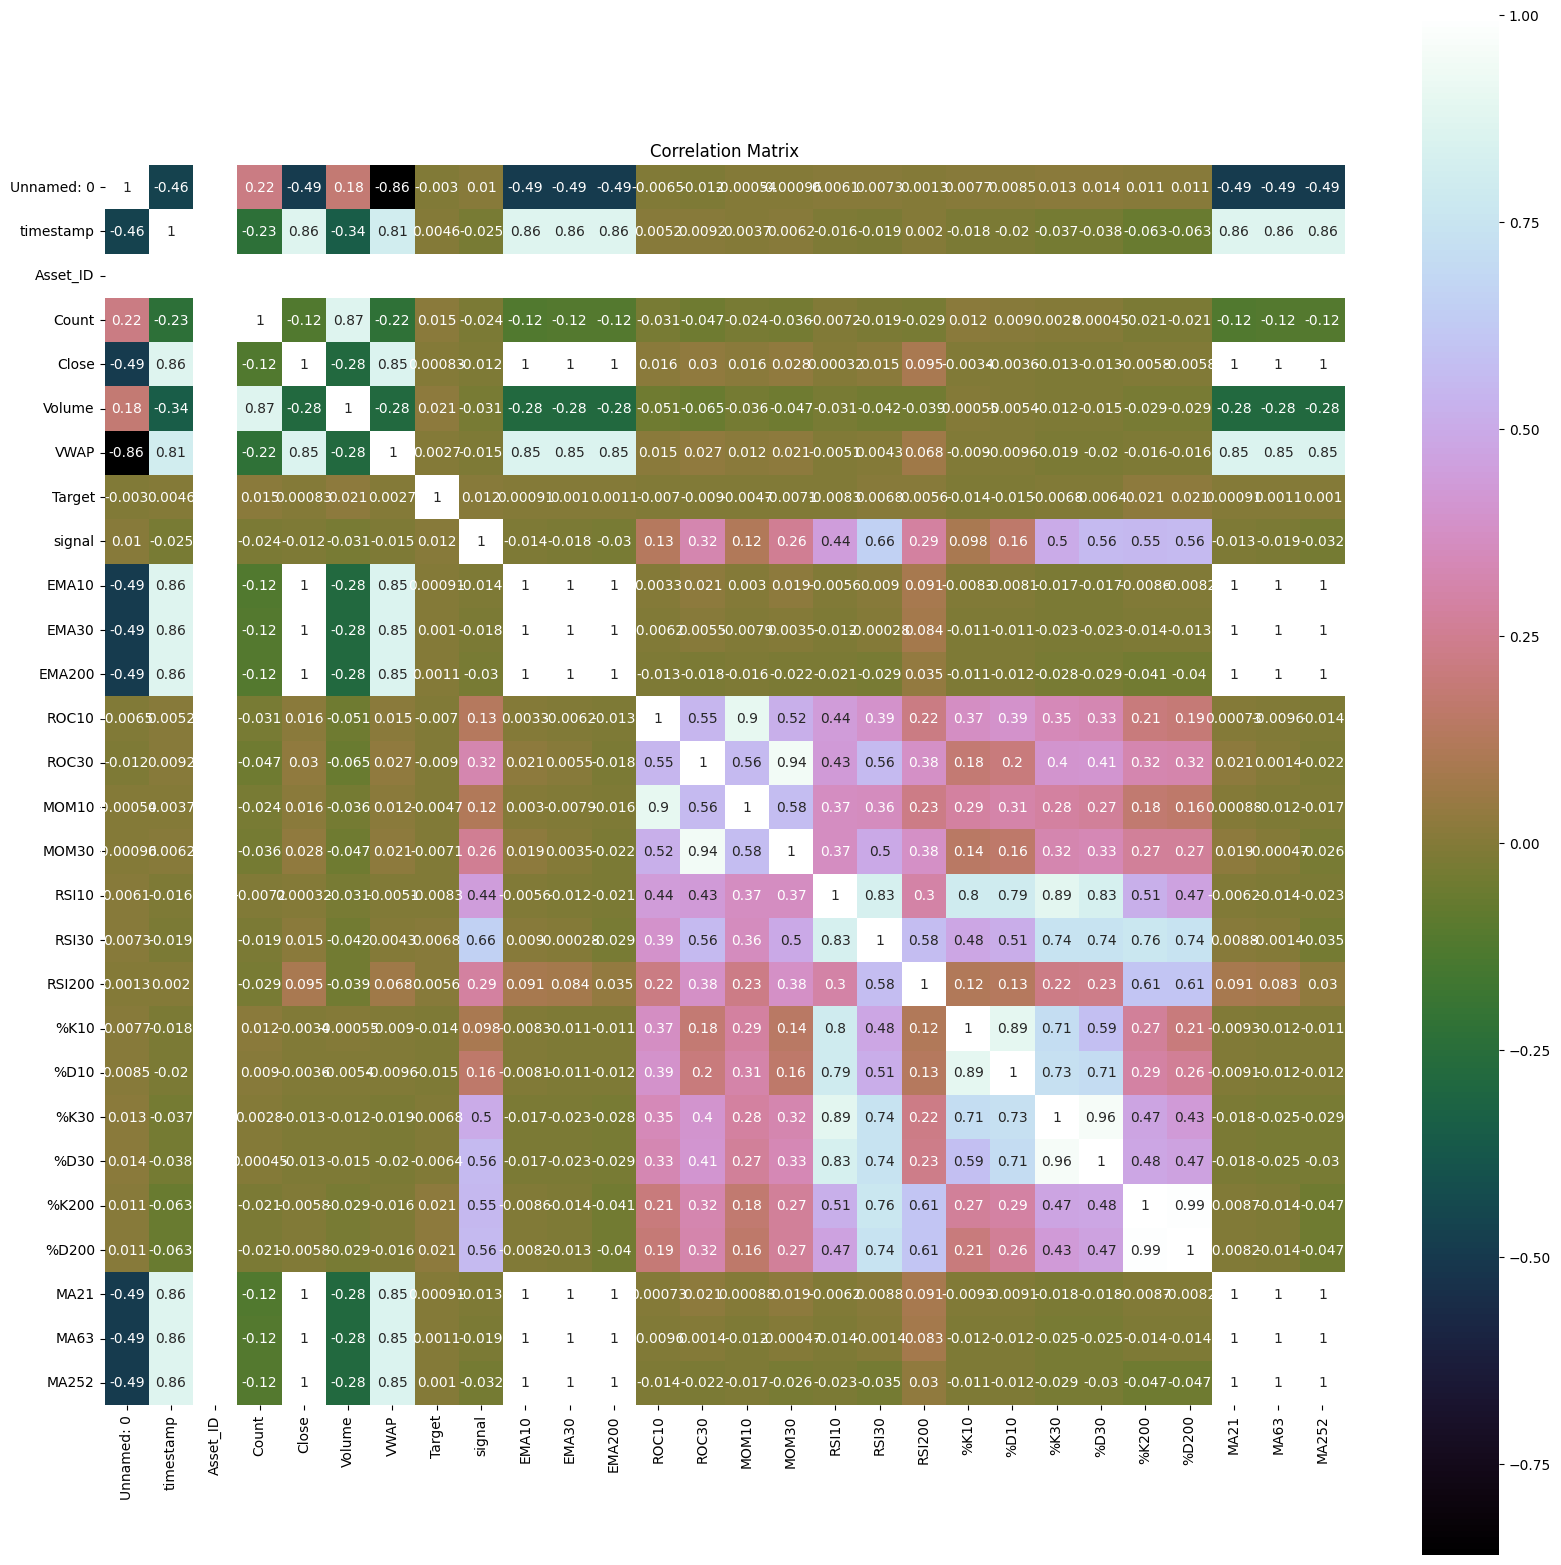

In [22]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## Models and Algorithms

### Train-Test-Split

We split the dataset into 80% training set and 20% test set.

In [23]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

### Evaluation Metrics and Test Options

In [24]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

### Compare Algorithms and Models

* In order to know which algorithm technic is the best for our strategy, we evaluate the following non linear different methods:

#### The Models

In [25]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# Neural Network
models.append(('NN', MLPClassifier()))
# Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

#### K-folds cross validation

In [26]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.507125 (0.007204)
LDA: 0.879362 (0.003960)
KNN: 0.956188 (0.003438)
CART: 0.896075 (0.003577)
NB: 0.725137 (0.007809)
NN: 0.501663 (0.008830)
AB: 0.876637 (0.006292)
GBM: 0.913575 (0.003560)
RF: 0.931725 (0.003333)


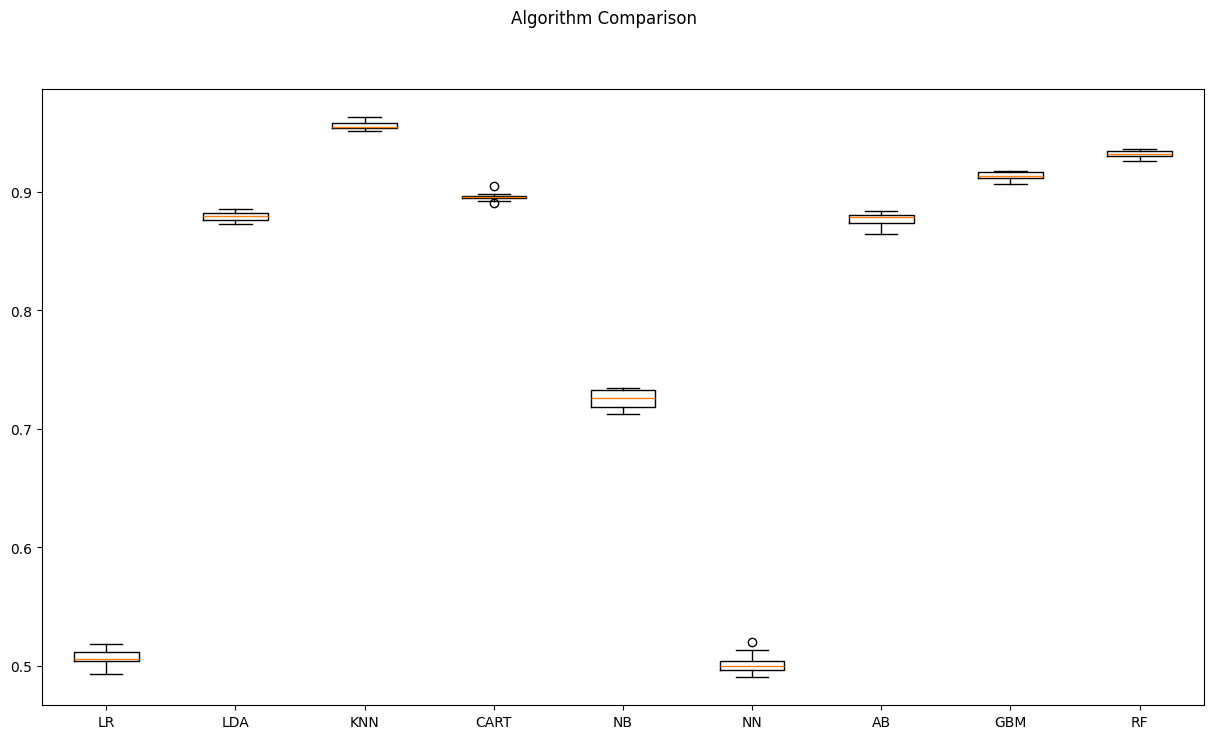

In [27]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()


## Tuning the Model and the Grid Search

*  Random forest is selected for the grid search as it is one of the best models out of them all.

In [28]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.916850 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.875425 (0.004613) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.878962 (0.005367) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.913488 (0.002988) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.916850 (0.002771) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.875425 (0.006878) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.878675 (0.003944) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.912975 (0.003278) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.914462 (0.003159) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Finalize the Model

Finalizing the model with best parameters found during tuning step.

#### Results on the Test Dataset

In [29]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression()
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [30]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9138
[[9215  871]
 [ 853 9061]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91     10086
         1.0       0.91      0.91      0.91      9914

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

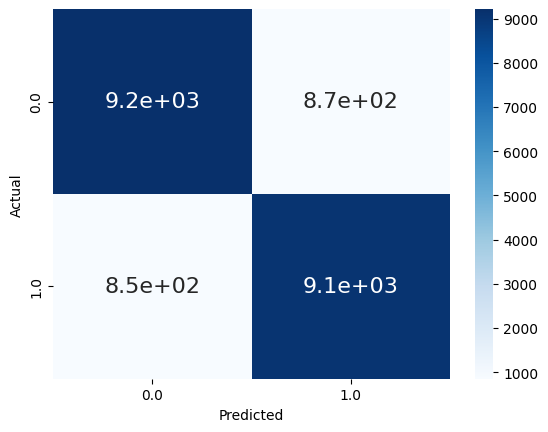

In [31]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

#### Feature Importance of the model

* Let's look into the Feature Importance of the Model

Text(0.5, 0, 'Variable Importance')

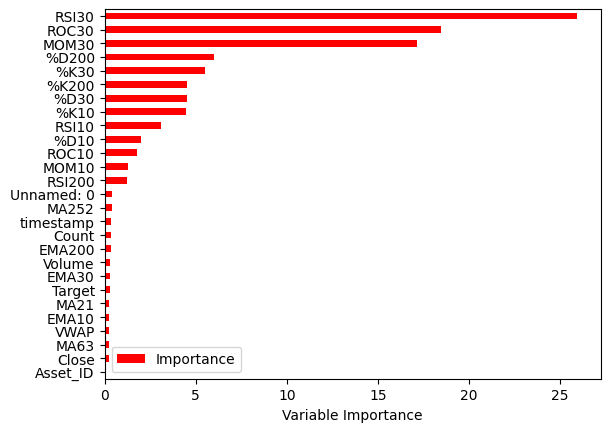

In [32]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

#### The Backtesting Results

<Axes: >

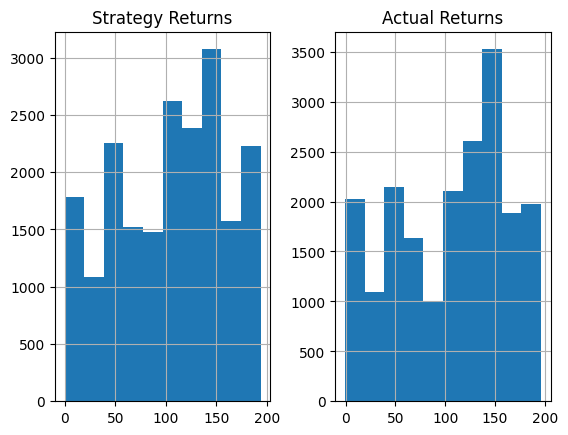

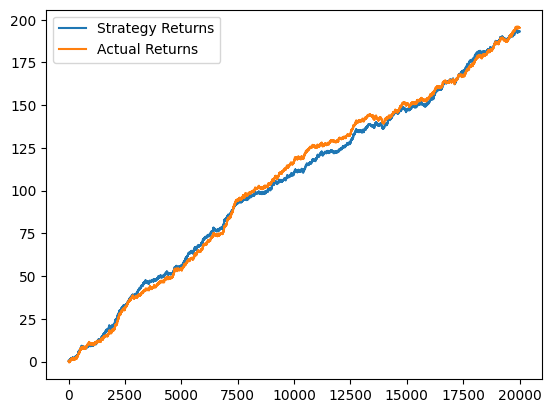

In [33]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [34]:
y_probs = model.predict_proba(X_validation)

# Probability that the model predicts "Buy" (class 1)
buy_probs = y_probs[:, 1]


In [35]:
signals = []
for p in buy_probs:
    if p > 0.65:       # Strong Buy confidence
        signals.append("BUY")
    elif p < 1.35:     # Strong Sell confidence
        signals.append("SELL")
    else:              # Uncertain
        signals.append("HOLD")


In [36]:
# Attach signals directly (aligns automatically by index)
dataset.loc[X_validation.index, "signal_pred"] = signals

# Now you can access it
print(dataset[["Close", "signal_pred"]].tail(20))


          Close signal_pred
475131  3590.01         nan
475132  3593.58         nan
475133  3590.46         nan
475134  3590.87         nan
475135  3592.79         nan
475136  3586.27         nan
475137  3582.99         nan
475138  3582.01         nan
475139  3579.14        SELL
475140  3584.84         nan
475141  3584.70        SELL
475142  3584.55         nan
475143  3583.66         nan
475144  3582.33         nan
475145  3584.41         nan
475146  3583.68         nan
475147  3585.34         nan
475148  3580.06         nan
475149  3577.26         nan
475150  3574.89         nan


In [37]:
print(dataset.columns.tolist())

['Unnamed: 0', 'timestamp', 'Asset_ID', 'Count', 'Close', 'Volume', 'VWAP', 'Target', 'signal', 'EMA10', 'EMA30', 'EMA200', 'ROC10', 'ROC30', 'MOM10', 'MOM30', 'RSI10', 'RSI30', 'RSI200', '%K10', '%D10', '%K30', '%D30', '%K200', '%D200', 'MA21', 'MA63', 'MA252', 'signal_pred']


In [38]:
# Directly assign by index (much cleaner)
dataset.loc[X_validation.index, "signal_pred"] = signals

print(dataset[["Close", "signal_pred"]].tail(20))


          Close signal_pred
475131  3590.01         nan
475132  3593.58         nan
475133  3590.46         nan
475134  3590.87         nan
475135  3592.79         nan
475136  3586.27         nan
475137  3582.99         nan
475138  3582.01         nan
475139  3579.14        SELL
475140  3584.84         nan
475141  3584.70        SELL
475142  3584.55         nan
475143  3583.66         nan
475144  3582.33         nan
475145  3584.41         nan
475146  3583.68         nan
475147  3585.34         nan
475148  3580.06         nan
475149  3577.26         nan
475150  3574.89         nan


In [39]:
predicted_signals_df = pd.DataFrame({"signal_pred_y": signals}, index=X_validation.index)

dataset = dataset.merge(predicted_signals_df, left_index=True, right_index=True, how="left")

print(dataset[["Close", "signal_pred_y"]].tail(20))


          Close signal_pred_y
475131  3590.01           NaN
475132  3593.58           NaN
475133  3590.46           NaN
475134  3590.87           NaN
475135  3592.79           NaN
475136  3586.27           NaN
475137  3582.99           NaN
475138  3582.01           NaN
475139  3579.14          SELL
475140  3584.84           NaN
475141  3584.70          SELL
475142  3584.55           NaN
475143  3583.66           NaN
475144  3582.33           NaN
475145  3584.41           NaN
475146  3583.68           NaN
475147  3585.34           NaN
475148  3580.06           NaN
475149  3577.26           NaN
475150  3574.89           NaN


In [40]:
# Drop duplicate prediction columns, keep only one
cols_to_drop = ['signal_pred_x', 'signal_pred_y_x', 'signal_pred_y_y']
dataset = dataset.drop(columns=[c for c in cols_to_drop if c in dataset.columns])

# Rename the remaining column to something consistent
dataset = dataset.rename(columns={'signal_pred': 'signal_pred_final'})

print(dataset[["Close", "signal_pred_final"]].tail(20))


          Close signal_pred_final
475131  3590.01               nan
475132  3593.58               nan
475133  3590.46               nan
475134  3590.87               nan
475135  3592.79               nan
475136  3586.27               nan
475137  3582.99               nan
475138  3582.01               nan
475139  3579.14              SELL
475140  3584.84               nan
475141  3584.70              SELL
475142  3584.55               nan
475143  3583.66               nan
475144  3582.33               nan
475145  3584.41               nan
475146  3583.68               nan
475147  3585.34               nan
475148  3580.06               nan
475149  3577.26               nan
475150  3574.89               nan


In [41]:
dataset["trade_action"] = dataset["signal_pred_final"].map({0: "SELL", 1: "BUY"})

print(dataset[["Close", "signal_pred_final", "trade_action"]].tail(20))


          Close signal_pred_final trade_action
475131  3590.01               nan          NaN
475132  3593.58               nan          NaN
475133  3590.46               nan          NaN
475134  3590.87               nan          NaN
475135  3592.79               nan          NaN
475136  3586.27               nan          NaN
475137  3582.99               nan          NaN
475138  3582.01               nan          NaN
475139  3579.14              SELL          NaN
475140  3584.84               nan          NaN
475141  3584.70              SELL          NaN
475142  3584.55               nan          NaN
475143  3583.66               nan          NaN
475144  3582.33               nan          NaN
475145  3584.41               nan          NaN
475146  3583.68               nan          NaN
475147  3585.34               nan          NaN
475148  3580.06               nan          NaN
475149  3577.26               nan          NaN
475150  3574.89               nan          NaN


In [42]:
dataset.loc[X_validation.index, "signal_pred_final"] = signals


In [43]:
# Convert numeric predictions to BUY/SELL first
dataset.loc[X_validation.index, "signal_pred_final"] = signals
dataset["trade_action"] = dataset["signal_pred_final"].map({0: "SELL", 1: "BUY"})

# Fill NaNs with HOLD
dataset["trade_action"] = dataset["trade_action"].fillna("HOLD")

print(dataset[["Close", "signal_pred_final", "trade_action"]].tail(20))


          Close signal_pred_final trade_action
475131  3590.01               nan         HOLD
475132  3593.58               nan         HOLD
475133  3590.46               nan         HOLD
475134  3590.87               nan         HOLD
475135  3592.79               nan         HOLD
475136  3586.27               nan         HOLD
475137  3582.99               nan         HOLD
475138  3582.01               nan         HOLD
475139  3579.14              SELL         HOLD
475140  3584.84               nan         HOLD
475141  3584.70              SELL         HOLD
475142  3584.55               nan         HOLD
475143  3583.66               nan         HOLD
475144  3582.33               nan         HOLD
475145  3584.41               nan         HOLD
475146  3583.68               nan         HOLD
475147  3585.34               nan         HOLD
475148  3580.06               nan         HOLD
475149  3577.26               nan         HOLD
475150  3574.89               nan         HOLD


In [44]:
validation_results = dataset.loc[X_validation.index, ["Close", "signal_pred_final"]]
validation_results["trade_action"] = validation_results["signal_pred_final"].map({0: "SELL", 1: "BUY"})
print(validation_results.tail(20))


              Close signal_pred_final trade_action
437436  2905.670000               BUY          NaN
391126  3492.380000              SELL          NaN
451714  4525.080000              SELL          NaN
384270  3981.300000              SELL          NaN
410409  3386.270000              SELL          NaN
407249  3505.850000              SELL          NaN
453308  3850.360000              SELL          NaN
381145  4615.740000              SELL          NaN
386756  4296.330000              SELL          NaN
441035  3867.680000              SELL          NaN
400953  4032.820000               BUY          NaN
378680  2955.498571              SELL          NaN
456448  4205.220000               BUY          NaN
413278  4691.710000               BUY          NaN
425763  4384.810000              SELL          NaN
448592  3555.510000              SELL          NaN
376492  3390.417830              SELL          NaN
447138  3077.400000              SELL          NaN
402061  4759.650000            

In [45]:
probs = model.predict_proba(X_validation)
buy_probs = probs[:, 1]  # probability of class = 1 (BUY)

actions = []
for p in buy_probs:
    if p > 0.65:
        actions.append("BUY")
    elif p < 0.35:
        actions.append("SELL")
    else:
        actions.append("HOLD")

dataset.loc[X_validation.index, "trade_action"] = actions


In [46]:
# If signal_pred_final already has BUY/SELL
dataset["trade_action"] = dataset["signal_pred_final"]

# Fill NaNs with HOLD
dataset["trade_action"] = dataset["trade_action"].fillna("HOLD")

print(dataset[["Close", "signal_pred_final", "trade_action"]].head(20))


          Close signal_pred_final trade_action
201  745.270000               nan          nan
202  744.350000               nan          nan
203  744.527143               nan          nan
204  745.116667               nan          nan
205  744.934738               nan          nan
206  744.982857               nan          nan
207  745.105714               nan          nan
208  745.671429               nan          nan
209  745.440000               nan          nan
210  745.491429               nan          nan
211  746.288333               nan          nan
212  746.610000               nan          nan
213  746.028721               nan          nan
214  746.085714               nan          nan
215  746.391429               nan          nan
216  746.058571               nan          nan
217  745.528571               nan          nan
218  745.547143               nan          nan
219  747.000000               nan          nan
220  747.647143               nan          nan


In [47]:
dataset["trade_action"] = dataset["signal_pred_final"].map({0: "SELL", 1: "BUY"})
dataset["trade_action"] = dataset["trade_action"].fillna("HOLD")


In [48]:
# --- Step 1: Get model predictions on validation set ---
# Predict probabilities (for better decision-making)
y_probs = model.predict_proba(X_validation)
buy_probs = y_probs[:, 1]  # probability of class 1 (BUY)

# --- Step 2: Convert probabilities into trading actions ---
actions = []
for p in buy_probs:
    if p > 0.65:        # confident BUY
        actions.append("BUY")
    elif p < 0.35:      # confident SELL
        actions.append("SELL")
    else:               # uncertain zone
        actions.append("HOLD")

# --- Step 3: Attach predictions back to dataset ---
dataset.loc[X_validation.index, "signal_pred_final"] = actions
dataset["trade_action"] = dataset["signal_pred_final"].fillna("HOLD")

# --- Step 4: View the final output ---
final_output = dataset.loc[X_validation.index, ["Close", "signal_pred_final", "trade_action"]]
print(final_output.tail(20))


              Close signal_pred_final trade_action
437436  2905.670000               BUY          BUY
391126  3492.380000              HOLD         HOLD
451714  4525.080000              SELL         SELL
384270  3981.300000              SELL         SELL
410409  3386.270000              SELL         SELL
407249  3505.850000              SELL         SELL
453308  3850.360000              SELL         SELL
381145  4615.740000              SELL         SELL
386756  4296.330000              HOLD         HOLD
441035  3867.680000              SELL         SELL
400953  4032.820000               BUY          BUY
378680  2955.498571              SELL         SELL
456448  4205.220000               BUY          BUY
413278  4691.710000               BUY          BUY
425763  4384.810000              SELL         SELL
448592  3555.510000              SELL         SELL
376492  3390.417830              SELL         SELL
447138  3077.400000              HOLD         HOLD
402061  4759.650000            

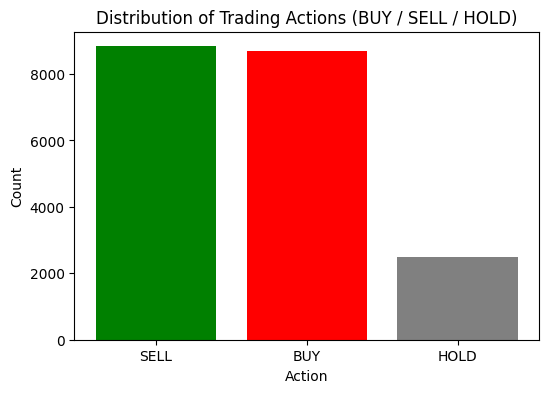

In [49]:
import matplotlib.pyplot as plt

# Count each action
action_counts = final_output["trade_action"].value_counts()

# Plot
plt.figure(figsize=(6,4))
plt.bar(action_counts.index, action_counts.values, color=["green","red","gray"])
plt.title("Distribution of Trading Actions (BUY / SELL / HOLD)")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()


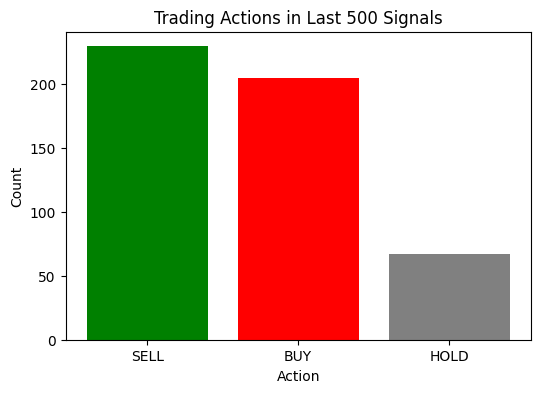

In [50]:
# Select last 500 rows from final_output
subset = final_output.tail(500)

# Count actions in this range
action_counts = subset["trade_action"].value_counts()

# Plot
plt.figure(figsize=(6,4))
plt.bar(action_counts.index, action_counts.values, color=["green","red","gray"])
plt.title("Trading Actions in Last 500 Signals")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()


In [51]:
# Convert if it's Unix time (seconds)
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], unit="s")

# (if it’s already in datetime-like format, Pandas will handle it correctly)


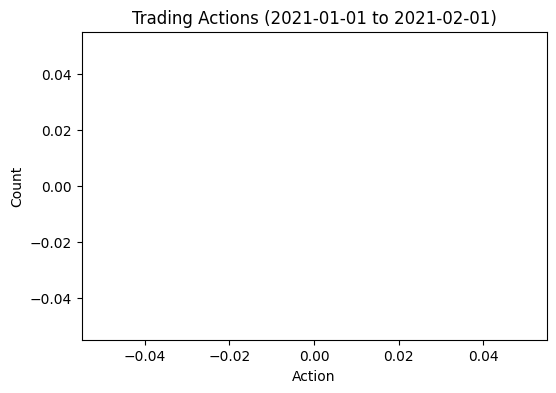

In [52]:
mask = (dataset["timestamp"] >= "2021-01-01") & (dataset["timestamp"] <= "2021-02-01")
subset = final_output.loc[mask]

# Count actions
action_counts = subset["trade_action"].value_counts()

# Plot
plt.figure(figsize=(6,4))
plt.bar(action_counts.index, action_counts.values, color=["green","red","gray"])
plt.title("Trading Actions (2021-01-01 to 2021-02-01)")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()


In [53]:
print("Min timestamp:", dataset["timestamp"].min())
print("Max timestamp:", dataset["timestamp"].max())


Min timestamp: 2021-01-01 03:22:00
Max timestamp: 2021-11-26 23:43:00


In [54]:
mask = (dataset["timestamp"] >= "2021-01-01") & (dataset["timestamp"] <= "2021-02-01")
print("Rows in range:", mask.sum())


Rows in range: 44438


In [55]:
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], unit="ms")


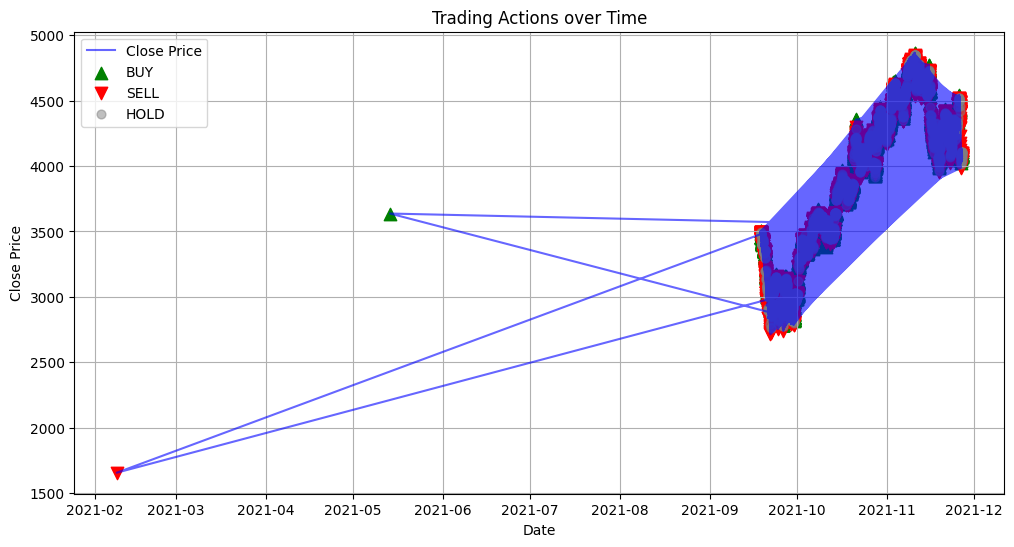

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Ensure timestamp is datetime ---
if pd.api.types.is_numeric_dtype(dataset["timestamp"]):
    if dataset["timestamp"].max() > 1e12:   # milliseconds
        dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], unit="ms")
    else:                                   # seconds
        dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])
else:
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

# --- Select full validation set (all predictions) ---
subset = dataset.loc[X_validation.index]

# --- Separate actions ---
buy_signals  = subset[subset["trade_action"] == "BUY"]
sell_signals = subset[subset["trade_action"] == "SELL"]
hold_signals = subset[subset["trade_action"] == "HOLD"]

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(subset["timestamp"], subset["Close"], label="Close Price", color="blue", alpha=0.6)

# Markers for actions
plt.scatter(buy_signals["timestamp"], buy_signals["Close"], marker="^", color="green", label="BUY", s=80)
plt.scatter(sell_signals["timestamp"], sell_signals["Close"], marker="v", color="red", label="SELL", s=80)
plt.scatter(hold_signals["timestamp"], hold_signals["Close"], marker="o", color="gray", label="HOLD", s=40, alpha=0.5)

plt.title("Trading Actions over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
!pip install mplfinance


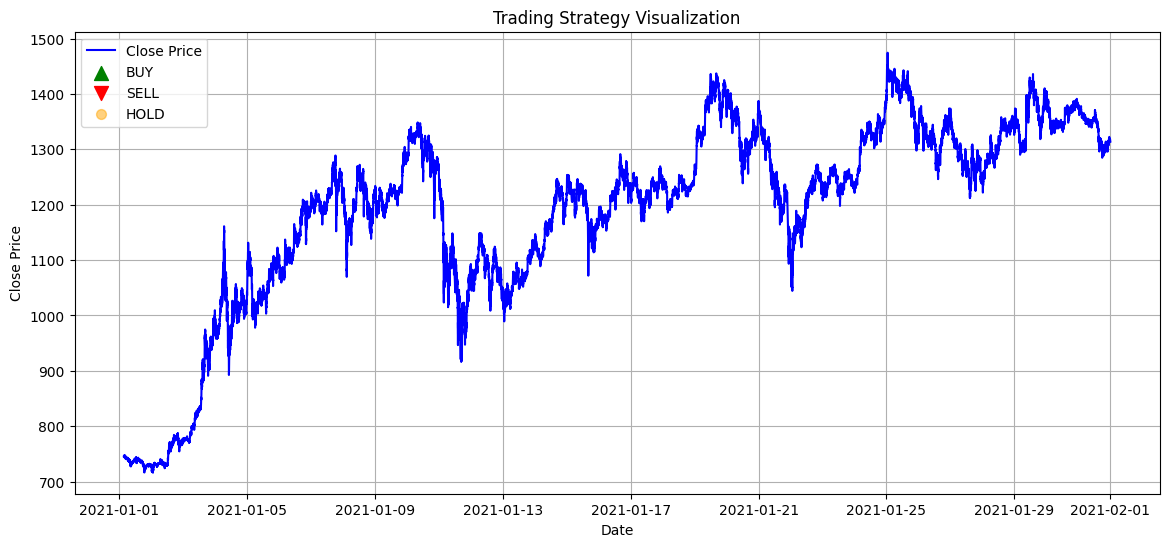

In [58]:
import matplotlib.pyplot as plt

# pick a time range (optional)
mask = (dataset["timestamp"] >= pd.to_datetime("2021-01-01")) & (dataset["timestamp"] <= pd.to_datetime("2021-02-01"))
subset = dataset.loc[mask].copy()

# plot close price
plt.figure(figsize=(14,6))
plt.plot(subset["timestamp"], subset["Close"], label="Close Price", color="blue")

# plot BUY / SELL / HOLD markers
buy_signals = subset[subset["trade_action"] == "BUY"]
sell_signals = subset[subset["trade_action"] == "SELL"]
hold_signals = subset[subset["trade_action"] == "HOLD"]

plt.scatter(buy_signals["timestamp"], buy_signals["Close"], marker="^", color="green", label="BUY", s=100)
plt.scatter(sell_signals["timestamp"], sell_signals["Close"], marker="v", color="red", label="SELL", s=100)
plt.scatter(hold_signals["timestamp"], hold_signals["Close"], marker="o", color="orange", label="HOLD", s=50, alpha=0.5)

plt.title("Trading Strategy Visualization")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


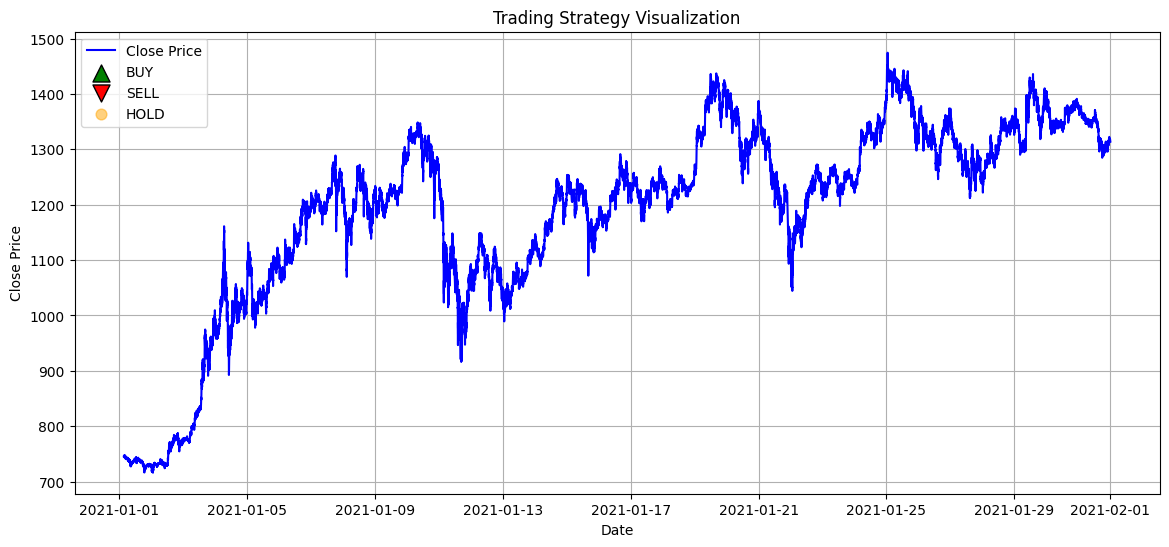

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# pick a time range (optional)
mask = (dataset["timestamp"] >= pd.to_datetime("2021-01-01")) & (dataset["timestamp"] <= pd.to_datetime("2021-02-01"))
subset = dataset.loc[mask].copy()

# plot close price
plt.figure(figsize=(14,6))
plt.plot(subset["timestamp"], subset["Close"], label="Close Price", color="blue")

# plot BUY / SELL markers
buy_signals = subset[subset["trade_action"] == "BUY"]
sell_signals = subset[subset["trade_action"] == "SELL"]
hold_signals = subset[(subset["trade_action"] == "HOLD") &
                      (~subset.index.isin(buy_signals.index)) &
                      (~subset.index.isin(sell_signals.index))]

plt.scatter(buy_signals["timestamp"], buy_signals["Close"], marker="^", color="green", label="BUY", s=150, edgecolor="black")
plt.scatter(sell_signals["timestamp"], sell_signals["Close"], marker="v", color="red", label="SELL", s=150, edgecolor="black")
plt.scatter(hold_signals["timestamp"], hold_signals["Close"], marker="o", color="orange", label="HOLD", s=60, alpha=0.5)

plt.title("Trading Strategy Visualization")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


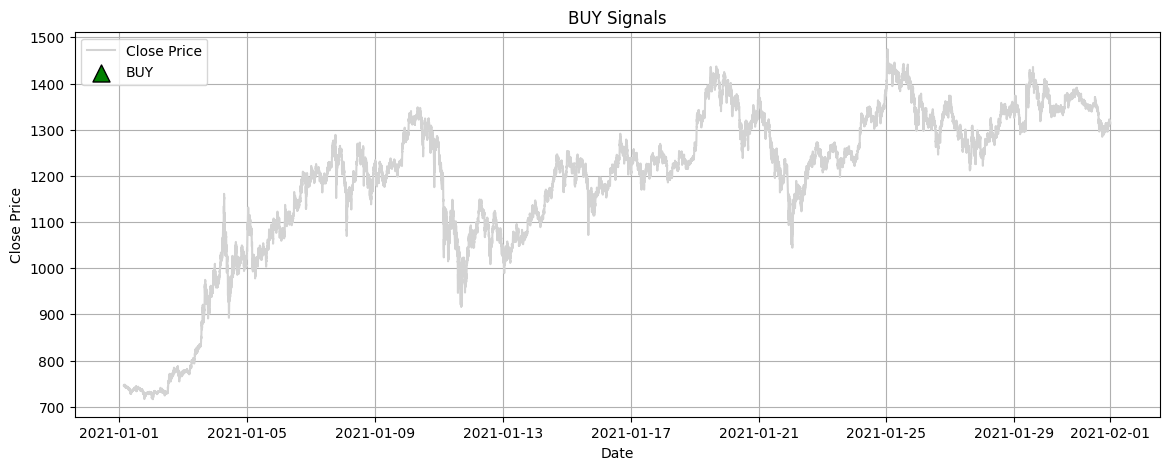

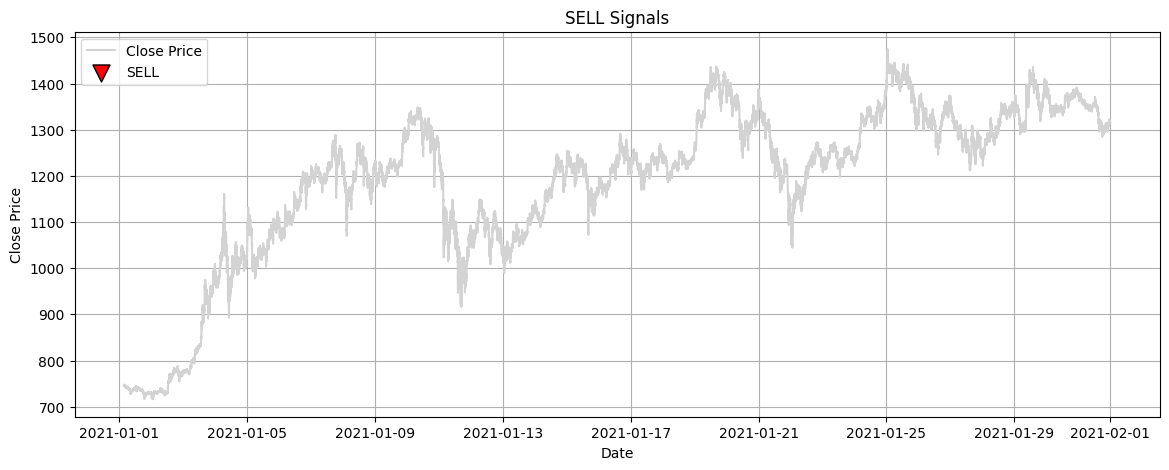

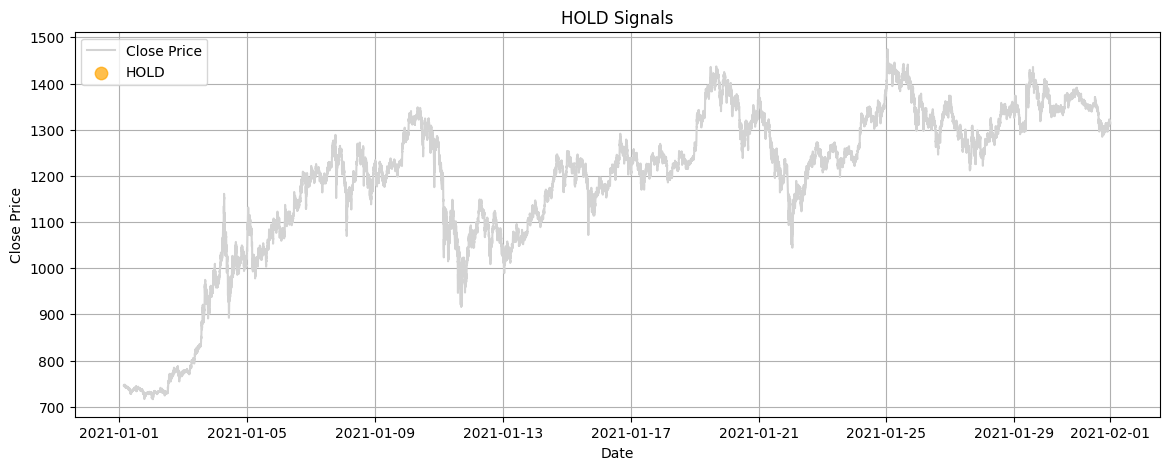

In [60]:
# BUY Graph
plt.figure(figsize=(14,5))
plt.plot(subset["timestamp"], subset["Close"], color="lightgray", label="Close Price")
plt.scatter(
    buy_signals["timestamp"], buy_signals["Close"],
    marker="^", color="green", s=150, label="BUY", edgecolor="black"
)
plt.title("BUY Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# SELL Graph
plt.figure(figsize=(14,5))
plt.plot(subset["timestamp"], subset["Close"], color="lightgray", label="Close Price")
plt.scatter(
    sell_signals["timestamp"], sell_signals["Close"],
    marker="v", color="red", s=150, label="SELL", edgecolor="black"
)
plt.title("SELL Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# HOLD Graph
plt.figure(figsize=(14,5))
plt.plot(subset["timestamp"], subset["Close"], color="lightgray", label="Close Price")
plt.scatter(
    hold_signals["timestamp"], hold_signals["Close"],
    marker="o", color="orange", s=80, alpha=0.7, label="HOLD"
)
plt.title("HOLD Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


No Buy signals found in dataset


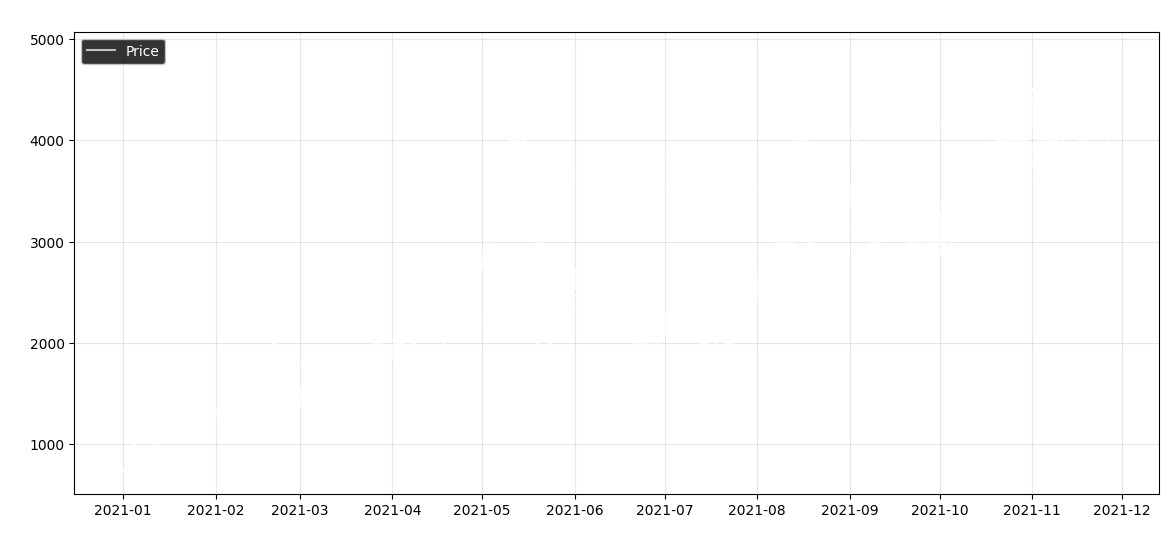

No Sell signals found in dataset


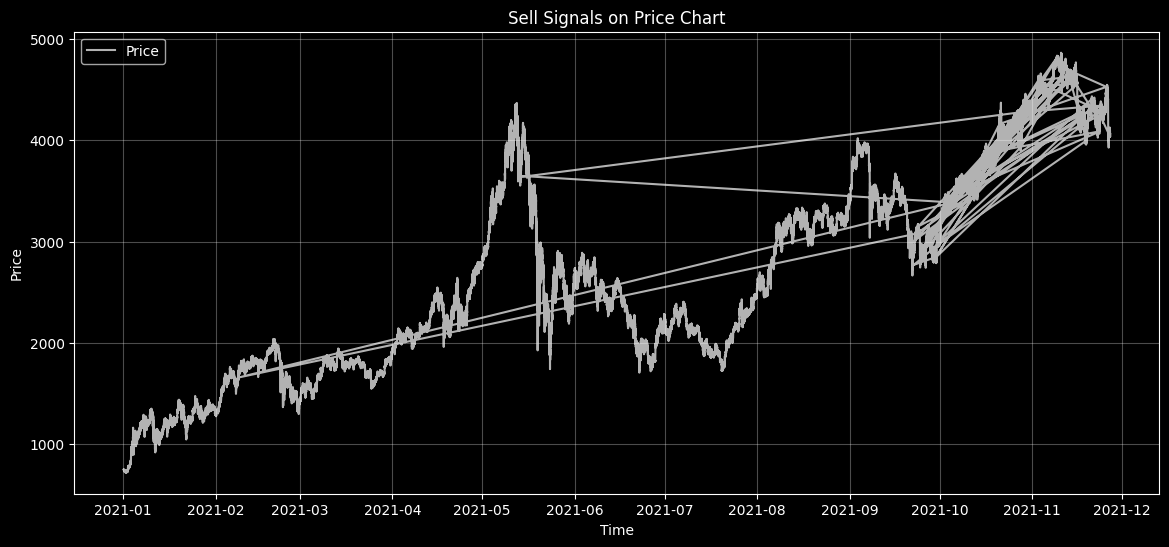

No Hold signals found in dataset


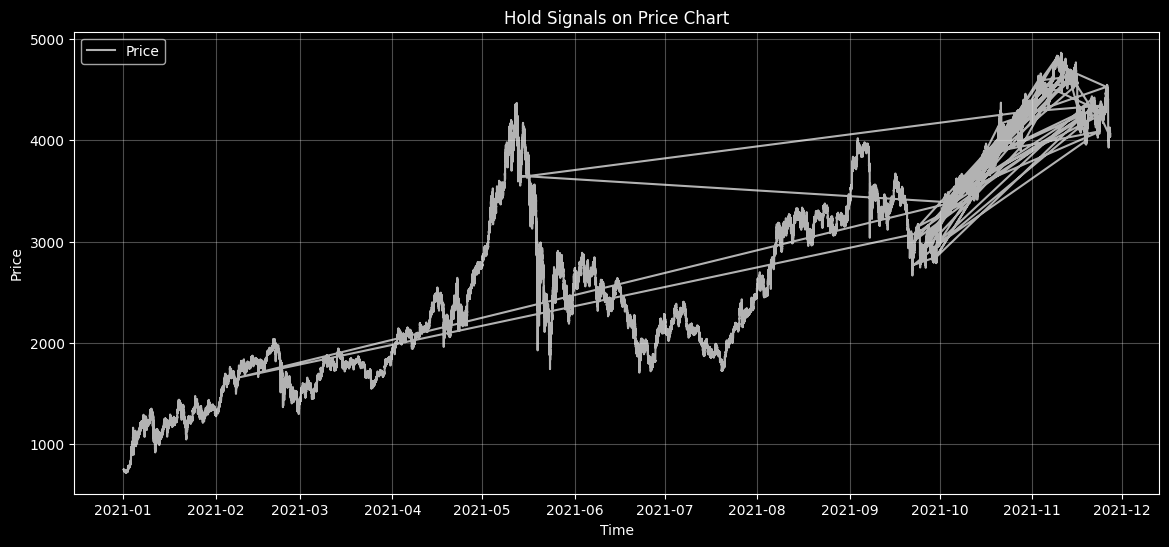

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure timestamp is datetime
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

# Function to plot action-specific chart
def plot_trade_action(dataset, action, color):
    plt.figure(figsize=(14,6))

    # Always plot the full price line
    plt.plot(dataset["timestamp"], dataset["Close"],
             color="white", label="Price", alpha=0.7)

    # Plot only the chosen action points
    df_action = dataset[dataset["trade_action"] == action]
    if not df_action.empty:
        plt.scatter(df_action["timestamp"], df_action["Close"],
                    color=color, label=action, s=60, marker="o", edgecolor="black")
    else:
        print(f"No {action} signals found in dataset")

    plt.title(f"{action} Signals on Price Chart", color="white")
    plt.xlabel("Time", color="white")
    plt.ylabel("Price", color="white")

    # Dark background
    plt.style.use("dark_background")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Plot separately
plot_trade_action(dataset, "Buy", "lime")
plot_trade_action(dataset, "Sell", "red")
plot_trade_action(dataset, "Hold", "yellow")


In [62]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the real feature columns (exclude Unnamed:0, timestamp, Target)
feature_names = ["Asset_ID", "Count", "Close", "Volume", "VWAP"]

# Save model + feature names
with open("price_prediction_model.pkl", "wb") as f:
    pickle.dump({"model": model, "feature_names": feature_names}, f)

# Load it back
with open("price_prediction_model.pkl", "rb") as f:
    model_data = pickle.load(f)

pickled_model = model_data["model"]
feature_names = model_data["feature_names"]

# Predict again on validation data
predictions = pickled_model.predict(X_validation)

# Evaluate
print("Accuracy:", accuracy_score(Y_validation, predictions))
print("Confusion Matrix:\n", confusion_matrix(Y_validation, predictions))
print("Classification Report:\n", classification_report(Y_validation, predictions))


Accuracy: 0.9138
Confusion Matrix:
 [[9215  871]
 [ 853 9061]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91     10086
         1.0       0.91      0.91      0.91      9914

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

